In [1]:
import sys
sys.path.append('/storage/vbutoi/projects')
sys.path.append('/storage/vbutoi/libraries')
sys.path.append('/storage/vbutoi/projects/ESE')
sys.path.append('/storage/vbutoi/projects/UniverSeg')

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")
sns.set_context("talk")

import os 
os.environ['DATAPATH'] = ':'.join((
       '/storage/vbutoi/datasets',
))

# Results loader object does everything
from ionpy.analysis import ResultsLoader
from pathlib import Path
root = Path("/storage/vbutoi/scratch/ESE")
rs = ResultsLoader()

# For using code without restarting.
%load_ext autoreload
%autoreload 2
# For using yaml configs.
%load_ext yamlmagic

In [2]:
%%yaml results_cfg 

log:
    root: /storage/vbutoi/scratch/ESE/inference
    inference_groups: 
        - "03_21_24_RandomCircles_RandomMiscalibratedEnsembles"
    
calibration:
    metric_cfg_file: "/storage/vbutoi/projects/ESE/ese/experiment/configs/inference/Calibration_Metrics.yaml"

options:
    add_baseline_rows: False 
    load_pixel_meters: False 
    add_dice_loss_rows: True
    drop_nan_metric_rows: True 
    load_groupavg_metrics: False
    remove_shared_columns: False
    equal_rows_per_cfg_assert: True 

<IPython.core.display.Javascript object>

In [3]:
from ese.experiment.analysis.analyze_inf import load_cal_inference_stats

image_info_df = load_cal_inference_stats(
    results_cfg=results_cfg,
    load_cached=False,
)

/local/vbutoi/envs/UniverSegTF/lib/python3.9/site-packages/pydantic/_internal/_fields.py:149: UserWarning: Field "model_outputs" has conflict with protected namespace "model_".

You may be able to resolve this warning by setting `model_config['protected_namespaces'] = ()`.
  warnings.warn(


Dropping (datapoint, metric) pairs with NaN metric score. Dropped from 92340 -> 92340 rows.
Finished loading inference stats.
Log amounts: log.root                                                                                                                log_set                                              
/storage/vbutoi/scratch/ESE/inference/03_21_24_RandomCircles_RandomMiscalibratedEnsembles/Shapes_Ensemble_Uncalibrated  20240321_172845-8VPT-da548ec0c9d006986cddb3da7c103b64    1620
                                                                                                                        20240321_172849-PYU7-eb5c251928c87b3e63a71a72e14b2292    1620
                                                                                                                        20240321_172852-U5LW-af10b5ba648a9bc317b64f91a4aed108    1620
                                                                                                                        20240321_172854-9HKT-

In [5]:
import ast
import numpy as np

# def temp_1(member_temps):
#     return ast.literal_eval(member_temps)[0]
# def temp_2(member_temps):
#     return ast.literal_eval(member_temps)[1]

def temp_mean(member_temps):
    return np.mean(ast.literal_eval(member_temps))

def temp_variance(member_temps):
    return np.var(ast.literal_eval(member_temps))

image_info_df.augment(temp_mean)
image_info_df.augment(temp_variance)

In [6]:
# Select only the rows corresponding to group methods
image_info_df = image_info_df[image_info_df['model_type'] == 'group']

image_info_df['method_name'] = image_info_df['method_name'].astype('category')
image_info_df['method_name'] = image_info_df['method_name'].cat.reorder_categories([
    'Ensemble (mean, probs)', 
])

image_info_df['split'] = image_info_df['split'].astype('category')
image_info_df['split'] = image_info_df['split'].cat.reorder_categories([
    'val',
    'cal'
])

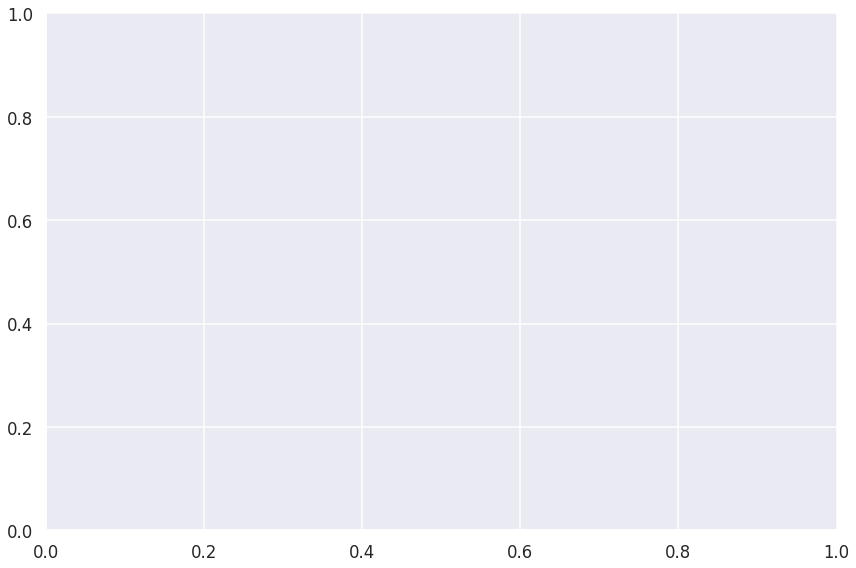

In [11]:
sns.relplot(
    data=image_info_df[image_info_df['image_metric'] == 'ECE'],
    x='temp_mean',
    y='temp_variance',
    hue='metric_score',
    col='split',
    kind='scatter',
    height=8,
    aspect=1.5,
    s=100,
    alpha=0.7,
)

# Let's looks at how the dice score varies as a function of the two temperatures.

In [7]:
# def group_by_config(in_df):
#     grouped_df = in_df.groupby([
#         'ensemble_hash',
#         'method_name',
#         'calibrator',
#         'split',
#         'member_temps',
#         'temp_1',
#         'temp_2',
#         'num_ensemble_members',
#     ])
#     # Mean over the metric_score columns
#     meaned_groups =  grouped_df.agg({'metric_score': 'mean'}).reset_index()
#     # Drop the NaN rows
#     grouped_cfg = meaned_groups.dropna().reset_index(drop=True)
#     return grouped_cfg

# metric_df_dict = {
#     "val_dice": group_by_config(image_info_df.select(
#         image_metric='Dice',
#         split='val'
#     )),
#     "cal_dice": group_by_config(image_info_df.select(
#         image_metric='Dice',
#         split='cal'
#     )),
#     "val_hd": group_by_config(image_info_df.select(
#         image_metric='HD95',
#         split='val'
#     )),
#     "cal_hd": group_by_config(image_info_df.select(
#         image_metric='HD95',
#         split='cal'
#     )),
#     "val_image_ece": group_by_config(image_info_df.select(
#         image_metric='Image_ECE',
#         split='val'
#     )),
#     "cal_image_ece": group_by_config(image_info_df.select(
#         image_metric='Image_ECE',
#         split='cal'
#     ))
# }

In [8]:
# pivot_df_dict = {
#     metric_class: metric_df.pivot_table(
#     index='temp_1',
#     columns='temp_2',
#     values='metric_score',
#     aggfunc='mean'
# )
# for metric_class, metric_df in metric_df_dict.items()
# }

In [9]:
# plt.figure(figsize=(15, 12))  # Adjust the size of the figure as desired

# g = sns.heatmap(
#     data=pivot_df_dict['val_dice'],
#     annot=True,
#     cmap='coolwarm_r',
#     fmt='.3f'
# )

# g.set_title('Validation Dice Score vs Temp 1 vs Temp 2')